In [2]:
%pip install tensorflow scikit-learn matplotlib seaborn Pillow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import MobileNetV2 # Or another base model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical # For one-hot encoding labels
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json # For loading class labels if you saved them

In [2]:
try:
    processed_data_path = 'cnn_processed_data.npz' # Path where you saved it
    if os.path.exists(processed_data_path):
        loaded_data = np.load(processed_data_path, allow_pickle=True)
        X_train = loaded_data['X_train']
        y_train = loaded_data['y_train']
        X_val = loaded_data['X_val']
        y_val = loaded_data['y_val']
        X_test = loaded_data['X_test']
        y_test = loaded_data['y_test']
        CATEGORIES = loaded_data['categories'].tolist() # Ensure it's a list

        IMG_HEIGHT, IMG_WIDTH = X_train.shape[1], X_train.shape[2]
        NUM_CLASSES = len(CATEGORIES)

        print("Preprocessed data loaded successfully from .npz file.")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"Categories: {CATEGORIES}, Num Classes: {NUM_CLASSES}")
    else:
        print(f"ERROR: Processed data file '{processed_data_path}' not found. Please run Phase A (data preparation) first.")
        # You might want to stop execution here if data isn't loaded
        # raise FileNotFoundError(f"Processed data file '{processed_data_path}' not found.")
except Exception as e:
    print(f"Error loading .npz file: {e}. Ensure the file was saved correctly in Phase A.")
    # Stop or handle error

Preprocessed data loaded successfully from .npz file.
X_train shape: (12, 224, 224, 3), y_train shape: (12,)
Categories: ['cyclone_visible', 'no_cyclone_visible'], Num Classes: 2


In [3]:
# These might be loaded from .npz or redefined if running cells from Phase A notebook
if 'IMG_HEIGHT' not in locals(): # Check if already defined (e.g. from loaded .npz)
    IMG_HEIGHT, IMG_WIDTH = 224, 224 
if 'NUM_CLASSES' not in locals():
    NUM_CLASSES = 2 # For 'cyclone_visible' vs 'no_cyclone_visible' (Update if different)
if 'CATEGORIES' not in locals():
    CATEGORIES = ["cyclone_visible", "no_cyclone_visible"] # Ensure this matches your data

print(f"Image Dimensions: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Class Categories: {CATEGORIES}")

# --- Load Pre-trained Base Model ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False # Freeze base model layers initially
print(f"Base model '{base_model.name}' loaded. Trainable: {base_model.trainable}")

# --- Add Custom Classification Head ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) 

if NUM_CLASSES == 2:
    predictions = Dense(1, activation='sigmoid')(x) 
    loss_function = 'binary_crossentropy'
    print("Configured for BINARY classification (Sigmoid + binary_crossentropy).")
elif NUM_CLASSES > 2:
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    loss_function = 'categorical_crossentropy'
    print(f"Configured for MULTI-CLASS classification ({NUM_CLASSES} classes, Softmax + categorical_crossentropy).")
else:
    print("ERROR: NUM_CLASSES must be 2 or greater.")
    raise ValueError("NUM_CLASSES must be 2 or greater.")


cnn_model = Model(inputs=base_model.input, outputs=predictions)

# --- Compile the Model ---
optimizer = Adam(learning_rate=0.0001) 
cnn_model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=['accuracy'])

print("\n--- CNN Model Summary ---")
cnn_model.summary()

# --- Prepare Labels for Training ---
# One-hot encode labels if using categorical_crossentropy
if loss_function == 'categorical_crossentropy':
    print("\nOne-hot encoding labels for categorical crossentropy...")
    if 'y_train' in locals() and y_train is not None:
        y_train_fit = to_categorical(y_train, num_classes=NUM_CLASSES)
        y_val_fit = to_categorical(y_val, num_classes=NUM_CLASSES)
        y_test_fit = to_categorical(y_test, num_classes=NUM_CLASSES) # For evaluation later
        print("Labels y_train, y_val, y_test one-hot encoded as y_train_fit, y_val_fit, y_test_fit.")
    else:
        print("ERROR: y_train, y_val, y_test not found for one-hot encoding. Load data first.")
elif loss_function == 'binary_crossentropy':
    print("\nUsing original labels (0 or 1) for binary crossentropy...")
    if 'y_train' in locals() and y_train is not None:
        # Ensure labels are not accidentally one-hot encoded if they shouldn't be
        if y_train.ndim > 1 and y_train.shape[1] > 1: 
            y_train_fit = np.argmax(y_train, axis=1)
            y_val_fit = np.argmax(y_val, axis=1)
            y_test_fit = np.argmax(y_test, axis=1)
            print("Warning: Labels appeared one-hot encoded, converted back to binary for binary_crossentropy.")
        else:
            y_train_fit = y_train
            y_val_fit = y_val
            y_test_fit = y_test # For evaluation later
        print("Labels y_train, y_val, y_test prepared as y_train_fit, y_val_fit, y_test_fit.")
    else:
        print("ERROR: y_train, y_val, y_test not found. Load data first.")
else:
    print("ERROR: Loss function not properly set for label preparation.")

Image Dimensions: 224x224
Number of Classes: 2
Class Categories: ['cyclone_visible', 'no_cyclone_visible']
Base model 'mobilenetv2_1.00_224' loaded. Trainable: False
Configured for BINARY classification (Sigmoid + binary_crossentropy).

--- CNN Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Using original labels (0 or 1) for binary crossentropy...
Labels y_train, y_val, y_test prepared as y_train_fit, y_val_fit, y_test_fit.



--- Starting Model Training ---
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.4167 - loss: 1.8747 - val_accuracy: 0.5000 - val_loss: 1.7082
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.3333 - loss: 2.1573 - val_accuracy: 0.5000 - val_loss: 1.5752
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.3333 - loss: 2.0443 - val_accuracy: 0.5000 - val_loss: 1.4563
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.2500 - loss: 1.9172 - val_accuracy: 0.2500 - val_loss: 1.3534
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - accuracy: 0.5833 - loss: 0.9751 - val_accuracy: 0.0000e+00 - val_loss: 1.2658
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3333 - loss: 1.1133 - val_accuracy: 0.0000e+00 - val_loss: 1.1902
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.5000 - loss: 0.7915 - val_accuracy: 0.0000e+00 - val_loss: 1.1319
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.5000 - loss:

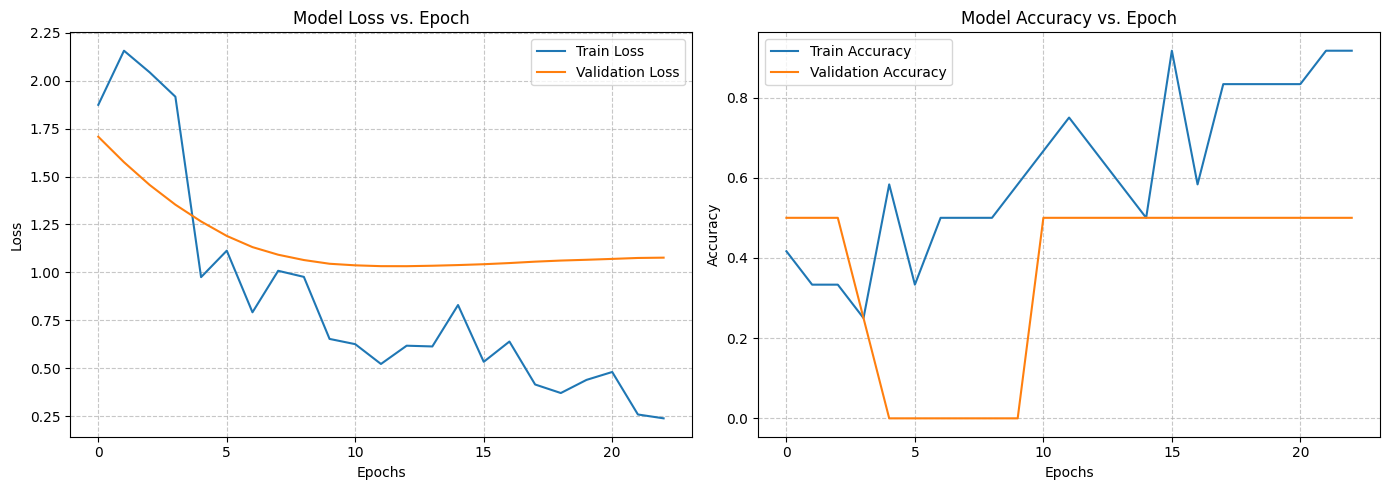

In [4]:
# cnn_training.ipynb (or .py script) - Model Training Part
# Ensure X_train, y_train_fit, X_val, y_val_fit are loaded and prepared from previous cells
# Also ensure NUM_CLASSES and loss_function are defined from the model compilation step.
# --- Callbacks ---
# Save the best model during training
checkpoint_filepath = 'ml_models/best_cyclone_cnn_checkpoint.keras' # Save in .keras format
# Ensure the ml_models directory exists
os.makedirs(os.path.dirname(checkpoint_filepath), exist_ok=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # Save the full model
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',              # Save when validation accuracy is max
    save_best_only=True)     # Only save the best model
# Stop training early if validation loss doesn't improve
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True) # Restore model weights from the epoch with the best value of the monitored quantity
# --- Training Parameters ---
EPOCHS = 50  # Start with a moderate number, can increase if needed (e.g., 20-100)
BATCH_SIZE = 32 # Common batch size, adjust based on your GPU memory
print("\n--- Starting Model Training ---")

# Check if necessary variables are defined from previous cells
if 'cnn_model' not in locals():
    print("ERROR: 'cnn_model' is not defined. Please define and compile the model first.")
elif 'X_train' not in locals() or 'y_train_fit' not in locals() or \
     'X_val' not in locals() or 'y_val_fit' not in locals():
    print("ERROR: Training/validation data (X_train, y_train_fit, X_val, y_val_fit) not found. Please load and prepare data first.")
else:
    history = None # Initialize history
    try:
        # The model.fit() call uses the prepared X_train, y_train_fit, X_val, y_val_fit
        history = cnn_model.fit(
            X_train, y_train_fit, # Use the appropriately formatted labels
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(X_val, y_val_fit), # Use the appropriately formatted labels
            callbacks=[model_checkpoint_callback, early_stopping_callback],
            verbose=1 # Show progress bar
        )
    except Exception as e:
        print(f"An error occurred during model training: {e}")
        import traceback
        traceback.print_exc()
if history and history.history: # Check if training happened and history object is valid
    print("\n--- Training Complete ---")
    # --- Plot Training History (Loss and Accuracy) ---
    # Check if history keys exist before trying to plot
    if 'loss' in history.history and 'val_loss' in history.history and \
       'accuracy' in history.history and 'val_accuracy' in history.history:
        
        plt.figure(figsize=(14, 5)) # Adjusted figure size
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss vs. Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy vs. Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("Could not plot training history: 'loss', 'val_loss', 'accuracy', or 'val_accuracy' not found in history object.")
elif history is None and 'cnn_model' in locals(): # Training was attempted but failed before .fit()
    print("Model training was not successfully initiated. Check for errors above.")
else: # Training didn't run or history object is invalid
    print("Model training did not produce a history object. Cannot plot metrics.")

In [5]:
# cnn_training.ipynb (or .py script) - Saving Final Model
FINAL_MODEL_PATH = os.path.join('ml_models', 'final_cyclone_detector_cnn.keras') # Use .keras format
os.makedirs(os.path.dirname(FINAL_MODEL_PATH), exist_ok=True)
# Assuming 'cnn_model' holds the best trained weights (e.g., from EarlyStopping or loaded from checkpoint)
try:
    cnn_model.save(FINAL_MODEL_PATH)
    print(f"Final trained CNN model saved to: {FINAL_MODEL_PATH}")
except Exception as e:
    print(f"Error saving final model: {e}")
# Also save the class labels (categories) in the correct order
CLASS_LABELS_PATH = os.path.join('ml_models', 'cnn_class_labels.json')
try:
    with open(CLASS_LABELS_PATH, 'w') as f:
        json.dump(CATEGORIES, f) # CATEGORIES should be ['cyclone_visible', 'no_cyclone_visible']
    print(f"Class labels saved to: {CLASS_LABELS_PATH}")
except Exception as e:
    print(f"Error saving class labels: {e}")


Final trained CNN model saved to: ml_models\final_cyclone_detector_cnn.keras
Class labels saved to: ml_models\cnn_class_labels.json
